# High level design:
  * forecasting model consist of following steps:
    * collecting and uploading the data
    * plotting the time-series data
    * Exploratory data analysis
    * make the time series data stationary
    * plotting the correlation and auto correlation plots
    * splitting the data into two parts as time series data cannot be splitted randomly.
    * building the model and validating it
    * deployment

In [1]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing the required modules :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

warnings.filterwarnings("ignore")

In [3]:
# Importing the required libraries::

data= pd.read_csv("Beds_occupied.csv")
data

,collection_date,Total Inpatient Beds
0,15/06/2020,293
1,16/06/2020,295
2,17/06/2020,290
3,18/06/2020,291
4,19/06/2020,288
...,...,...
361,11/06/2021,312
362,12/06/2021,212
363,13/06/2021,299
364,14/06/2021,202


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   collection_date       366 non-null    object
 1   Total Inpatient Beds  366 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [5]:
data

,collection_date,Total Inpatient Beds
0,15/06/2020,293
1,16/06/2020,295
2,17/06/2020,290
3,18/06/2020,291
4,19/06/2020,288
...,...,...
361,11/06/2021,312
362,12/06/2021,212
363,13/06/2021,299
364,14/06/2021,202


In [6]:
data["total_beds"]= 900
data

,collection_date,Total Inpatient Beds,total_beds
0,15/06/2020,293,900
1,16/06/2020,295,900
2,17/06/2020,290,900
3,18/06/2020,291,900
4,19/06/2020,288,900
...,...,...,...
361,11/06/2021,312,900
362,12/06/2021,212,900
363,13/06/2021,299,900
364,14/06/2021,202,900


In [7]:
d=data.collection_date.astype("datetime64[ns]")
d

0     2020-06-15
1     2020-06-16
2     2020-06-17
3     2020-06-18
4     2020-06-19
         ...    
361   2021-11-06
362   2021-12-06
363   2021-06-13
364   2021-06-14
365   2021-06-15
Name: collection_date, Length: 366, dtype: datetime64[ns]

In [8]:
data.describe()

,Total Inpatient Beds,total_beds
count,366.000000,366.0
mean,241.983607,900.0
std,28.658017,0.0
min,190.000000,900.0
25%,219.000000,900.0
50%,237.000000,900.0
75%,259.000000,900.0
max,341.000000,900.0


In [9]:
data["Available_beds"]=data["total_beds"]-data["Total Inpatient Beds"]

In [10]:
data= data[["collection_date","Available_beds"]]

In [11]:
data

,collection_date,Available_beds
0,15/06/2020,607
1,16/06/2020,605
2,17/06/2020,610
3,18/06/2020,609
4,19/06/2020,612
...,...,...
361,11/06/2021,588
362,12/06/2021,688
363,13/06/2021,601
364,14/06/2021,698


In [12]:
train_data= data[:186]
train_data

,collection_date,Available_beds
0,15/06/2020,607
1,16/06/2020,605
2,17/06/2020,610
3,18/06/2020,609
4,19/06/2020,612
...,...,...
181,13/12/2020,622
182,14/12/2020,646
183,15/12/2020,628
184,16/12/2020,622


In [13]:
test_data= data[186:]
test_data

,collection_date,Available_beds
186,18/12/2020,655
187,19/12/2020,652
188,20/12/2020,688
189,21/12/2020,653
190,22/12/2020,686
...,...,...
361,11/06/2021,588
362,12/06/2021,688
363,13/06/2021,601
364,14/06/2021,698


## Exploratory Data Analysis [EDA] :

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   collection_date  186 non-null    object
 1   Available_beds   186 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [15]:
train_data.describe()

,Available_beds
count,186.000000
mean,653.629032
std,30.149484
min,559.000000
25%,623.000000
50%,658.000000
75%,680.000000
max,707.000000


In [16]:
train_data.isnull().sum()

collection_date    0
Available_beds     0
dtype: int64

* Here we can see that there are no null values

In [17]:
train_data[train_data.duplicated()].sum()

collection_date    0.0
Available_beds     0.0
dtype: float64



* There are no duplicated values as well

In [18]:
train_data.dtypes

collection_date    object
Available_beds      int64
dtype: object

* Here, The collection_date is in the format of object. just change that to Datetime64[ns]

In [19]:
train_data["collection_date"]= pd.to_datetime(train_data["collection_date"])

* Here, we have converted the collection_date to Datetime64[ns]

In [20]:
train_data.dtypes

collection_date    datetime64[ns]
Available_beds              int64
dtype: object

* now, the collection is changed to Datetime64[ns]

In [21]:
train_data["collection_date"]= train_data["collection_date"].dt.strftime("%d-%m-%y")
train_data["collection_date"]= train_data["collection_date"].astype("datetime64[ns]")

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   collection_date  186 non-null    datetime64[ns]
 1   Available_beds   186 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


In [23]:
print(train_data.min())
print(train_data.max())

collection_date    2020-06-15 00:00:00
Available_beds                     559
dtype: object
collection_date    2020-12-17 00:00:00
Available_beds                     707
dtype: object


* 559, 701 are the minimum and the maximum values of the Data-set

In [24]:
# print(pd.date_range(start="2020-06-15", end="2021-06-15").difference(train_data["collection_date"]))

## Visualization of the dataset:

<AxesSubplot:>

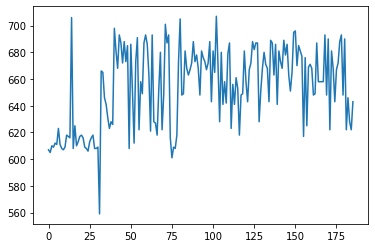

In [25]:
train_data.Available_beds.plot()

In [26]:
train_data["month"]= pd.DatetimeIndex(train_data["collection_date"]).month

<AxesSubplot:xlabel='month', ylabel='Available_beds'>

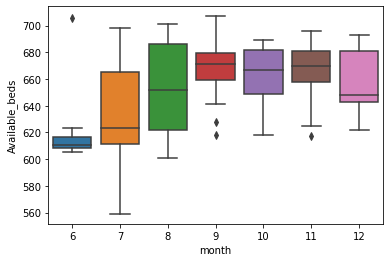

In [27]:
sns.boxplot(train_data["month"], train_data["Available_beds"])

<AxesSubplot:>

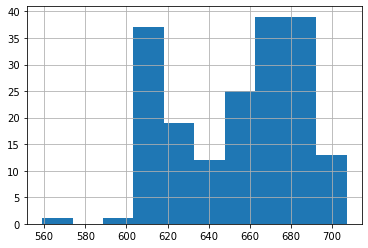

In [28]:
train_data["Available_beds"].hist()

* HISTOGRAM

<AxesSubplot:ylabel='Density'>

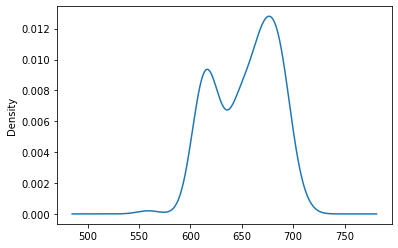

In [29]:
train_data["Available_beds"].plot(kind="kde")

## ACF & PACF PLOT:

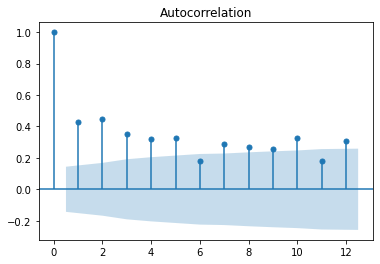

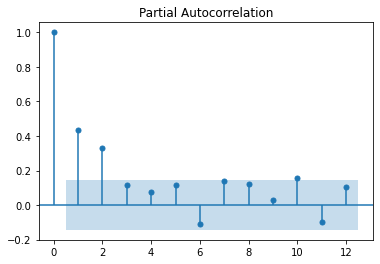

In [149]:
import statsmodels.graphics.tsaplots as tsa_plot

tsa_plot.plot_acf(train_data["Available_beds"], lags= 12)
tsa_plot.plot_pacf(train_data["Available_beds"], lags= 12)
plt.show()

* DENSITY PLOT

In [30]:
# making the collection_date as index of the dataset:

train_data.index= train_data["collection_date"]

train_data= train_data[["Available_beds"]]

train_data

,Available_beds
collection_date,
2020-06-15,607
2020-06-16,605
2020-06-17,610
2020-06-18,609
2020-06-19,612
...,...
2020-12-13,622
2020-12-14,646
2020-12-15,628


## Checking for stationarity of the dataset:

In [31]:
# H0: the data is stationarity
# H1: the data is non- Stationarity

def addfull(data):
    values= adfuller(data)
    labels=("add_fuller_statistics","p_values","no of lags","no of observations used")
    for values,labels in zip(values,labels):
        print(labels +":"+ str(values))
        
#     if values[1] <=0.05:
#         print("The H0 is rejected and the data is stationary")
        
#     else:
#         print("The H1 is rejected and the data is non-statonary")
        

In [32]:
addfull(train_data["Available_beds"])

add_fuller_statistics:-2.711414288225288
p_values:0.0720838400105457
no of lags:7
no of observations used:178


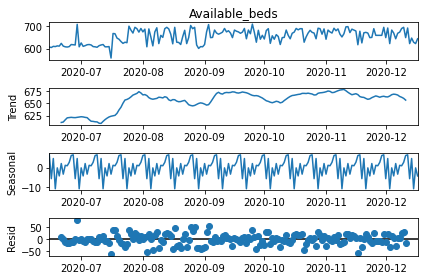

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

d= seasonal_decompose(train_data["Available_beds"], period= 12)
d.plot()
plt.show()

* DECOMPOSE PLOT

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

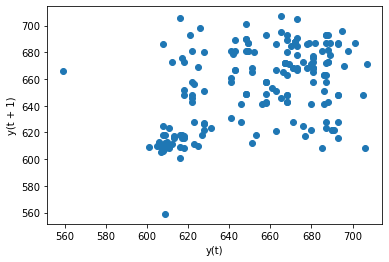

In [34]:
from pandas.plotting import lag_plot

lag_plot(train_data.Available_beds)

* Lag Plot

## Outlier detection using Isolation forest:

In [35]:
from sklearn.ensemble import IsolationForest

In [36]:
model= IsolationForest(contamination=0.02)

out=model.fit_predict(train_data)

In [37]:
train_data["outlier_values"]= out

<AxesSubplot:xlabel='outlier_values', ylabel='count'>

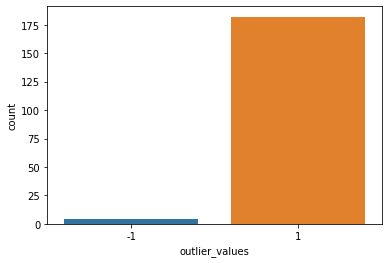

In [38]:
sns.countplot(train_data["outlier_values"])

In [39]:
train_data[train_data["outlier_values"]==-1]

,Available_beds,outlier_values
collection_date,,
2020-07-16,559,-1
2020-08-29,601,-1
2020-09-03,705,-1
2020-09-25,707,-1


In [40]:
# before imputation change these values to the nan values:

train_data["Available_beds"]= train_data["Available_beds"].replace([601,559,705,707], np.nan)

In [41]:
m=(train_data["Available_beds"]).mean()
m=int(m)
m



653

In [42]:
# imputing the outliers with the mean values:

train_data["Available_beds"]= train_data["Available_beds"].fillna(m)
train_data= train_data[["Available_beds"]]

In [43]:
t=pd.DataFrame(train_data["Available_beds"].astype("int"))
t

,Available_beds
collection_date,
2020-06-15,607
2020-06-16,605
2020-06-17,610
2020-06-18,609
2020-06-19,612
...,...
2020-12-13,622
2020-12-14,646
2020-12-15,628


In [44]:
train_data

,Available_beds
collection_date,
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0
...,...
2020-12-13,622.0
2020-12-14,646.0
2020-12-15,628.0


In [45]:
Data=train_data.values
Data

array([[607.],
       [605.],
       [610.],
       [609.],
       [612.],
       [611.],
       [623.],
       [611.],
       [608.],
       [607.],
       [609.],
       [618.],
       [617.],
       [616.],
       [706.],
       [608.],
       [625.],
       [610.],
       [613.],
       [617.],
       [618.],
       [616.],
       [609.],
       [608.],
       [606.],
       [613.],
       [616.],
       [618.],
       [608.],
       [608.],
       [609.],
       [653.],
       [666.],
       [665.],
       [646.],
       [641.],
       [631.],
       [623.],
       [628.],
       [626.],
       [698.],
       [681.],
       [668.],
       [693.],
       [687.],
       [672.],
       [688.],
       [673.],
       [685.],
       [608.],
       [686.],
       [651.],
       [612.],
       [673.],
       [691.],
       [622.],
       [658.],
       [649.],
       [687.],
       [693.],
       [686.],
       [663.],
       [621.],
       [693.],
       [628.],
       [627.],
       [61

In [46]:
# test_data["collection_date"]= test_data["collection_date"].dt.strftime("%d-%m-%y")
test_data["collection_date"]= test_data["collection_date"].astype("datetime64[ns]")

In [47]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 186 to 365
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   collection_date  180 non-null    datetime64[ns]
 1   Available_beds   180 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.9 KB


In [48]:
test_data["collection_date"]= test_data["collection_date"].dt.strftime("%d-%m-%y")


In [49]:
test_data["collection_date"]= test_data["collection_date"].astype("datetime64[ns]")

In [50]:
test_data.index= test_data["collection_date"]

In [51]:

test_data= test_data[["Available_beds"]]
test_data

,Available_beds
collection_date,
2020-12-18,655
2020-12-19,652
2020-12-20,688
2020-12-21,653
2020-12-22,686
...,...
2021-06-11,588
2021-06-12,688
2021-06-13,601


## Model Building :

### Naive model:

In [52]:
# naive_model = ARIMA(train_data, order=())
Data
Data.astype("float32")

test_size= int(len(train_data)*0.5)
test_size

93

In [53]:
tr_data= Data[:test_size]
tst_data= Data[test_size:]

In [54]:
tr_data.shape

(93, 1)

In [55]:
tst_data.shape

(93, 1)

In [56]:
from math import sqrt

history= [x for x in tr_data]

prediction=list()
for i in range(len(tst_data)):
    a=history[-1]
    prediction.append(a)
    
    obs= tst_data[i]
    history.append(obs)
    print(">expected=%.03f,prediction=%.03f"%(a,obs))
    
rmse=sqrt(mean_squared_error(tst_data, prediction))
print(rmse)

>expected=648.000,prediction=681.000
>expected=681.000,prediction=676.000
>expected=676.000,prediction=673.000
>expected=673.000,prediction=667.000
>expected=667.000,prediction=672.000
>expected=672.000,prediction=688.000
>expected=688.000,prediction=643.000
>expected=643.000,prediction=681.000
>expected=681.000,prediction=665.000
>expected=665.000,prediction=653.000
>expected=653.000,prediction=671.000
>expected=671.000,prediction=628.000
>expected=628.000,prediction=680.000
>expected=680.000,prediction=641.000
>expected=641.000,prediction=658.000
>expected=658.000,prediction=642.000
>expected=642.000,prediction=679.000
>expected=679.000,prediction=687.000
>expected=687.000,prediction=623.000
>expected=623.000,prediction=656.000
>expected=656.000,prediction=641.000
>expected=641.000,prediction=661.000
>expected=661.000,prediction=653.000
>expected=653.000,prediction=618.000
>expected=618.000,prediction=648.000
>expected=648.000,prediction=649.000
>expected=649.000,prediction=681.000
>

### Hyper tunning the parameters in ARIMA:

In [57]:
train_data.values

array([[607.],
       [605.],
       [610.],
       [609.],
       [612.],
       [611.],
       [623.],
       [611.],
       [608.],
       [607.],
       [609.],
       [618.],
       [617.],
       [616.],
       [706.],
       [608.],
       [625.],
       [610.],
       [613.],
       [617.],
       [618.],
       [616.],
       [609.],
       [608.],
       [606.],
       [613.],
       [616.],
       [618.],
       [608.],
       [608.],
       [609.],
       [653.],
       [666.],
       [665.],
       [646.],
       [641.],
       [631.],
       [623.],
       [628.],
       [626.],
       [698.],
       [681.],
       [668.],
       [693.],
       [687.],
       [672.],
       [688.],
       [673.],
       [685.],
       [608.],
       [686.],
       [651.],
       [612.],
       [673.],
       [691.],
       [622.],
       [658.],
       [649.],
       [687.],
       [693.],
       [686.],
       [663.],
       [621.],
       [693.],
       [628.],
       [627.],
       [61

In [58]:
 # evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
        

In [59]:
                    
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [60]:
train=train_data["Available_beds"]
train.values

array([607., 605., 610., 609., 612., 611., 623., 611., 608., 607., 609.,
       618., 617., 616., 706., 608., 625., 610., 613., 617., 618., 616.,
       609., 608., 606., 613., 616., 618., 608., 608., 609., 653., 666.,
       665., 646., 641., 631., 623., 628., 626., 698., 681., 668., 693.,
       687., 672., 688., 673., 685., 608., 686., 651., 612., 673., 691.,
       622., 658., 649., 687., 693., 686., 663., 621., 693., 628., 627.,
       618., 652., 680., 622., 648., 701., 687., 693., 616., 653., 609.,
       608., 618., 673., 653., 648., 649., 681., 668., 663., 667., 672.,
       688., 673., 678., 668., 648., 681., 676., 673., 667., 672., 688.,
       643., 681., 665., 653., 671., 628., 680., 641., 658., 642., 679.,
       687., 623., 656., 641., 661., 653., 618., 648., 649., 681., 658.,
       643., 667., 672., 688., 682., 687., 687., 628., 651., 668., 680.,
       671., 668., 643., 689., 687., 663., 686., 641., 681., 673., 668.,
       689., 678., 686., 663., 651., 665., 695., 69

In [61]:
data.shape

(366, 2)

In [62]:
p_value= range(0,5)
d_value= range(0,5)
q_value= range(0,5)

evaluate_models(train_data,p_value,d_value, q_value)

### Splitting the data into train & test:

In [63]:
tr= train_data[:140]
tr
test= train_data[140:]
test

,Available_beds
collection_date,
2020-11-02,681.0
2020-11-03,673.0
2020-11-04,668.0
2020-11-05,689.0
2020-11-06,678.0
2020-11-07,686.0
2020-11-08,663.0
2020-11-09,651.0
2020-11-10,665.0


### ARIMA Model

In [64]:


model_arima = ARIMA(tr.values.astype("float32"), order=(0,0,0))
model_arima_fit = model_arima.fit(disp=0)

test["forecasted"]=model_arima_fit.forecast(steps=46)[0]
# test["forcasted"].shape
test["Available_beds"].shape





# plt.figure(figsize=(12,8))
# plt.plot(yhat, label="Predictions")
# plt.plot()

(46,)

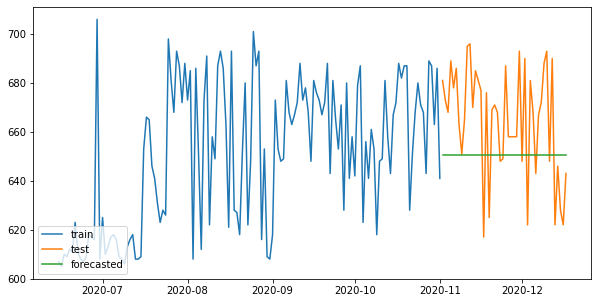

In [65]:
plt.figure(figsize=(10,5))
plt.plot(tr, label = "train")
plt.plot(test["Available_beds"], label="test")
plt.plot(test["forecasted"], label= "forecasted")
plt.legend(loc="lower left")
plt.show()

In [66]:
# import pandas as pd

# date= pd.date_range(start="16-06-2021", end= "15-07-2021").to_pydatetime().tolist()

#### ARIMA Train_RMSE

In [128]:
train_rmse= sqrt(mean_squared_error(test["forecasted"], test["Available_beds"]))

train_rmse

26.08194984674924

#### ARIMA Test_RMSE:

In [69]:
val_tr= test_data[:120]
val_tr


val_test= test_data[120:]



In [68]:
test_data

,Available_beds
collection_date,
2020-12-18,655
2020-12-19,652
2020-12-20,688
2020-12-21,653
2020-12-22,686
...,...
2021-06-11,588
2021-06-12,688
2021-06-13,601


In [70]:
X= val_tr.values
X= X.astype("float32")
val_model = ARIMA(X, order=(0,0,4))
model_fit= val_model.fit(disp=0)
yhat = model_fit.forecast(steps= 60)[0]

In [71]:
rmse_test= sqrt(mean_squared_error(yhat, val_test))
rmse_test

28.886421981439454

#### ARIMA RMSE FOR THE WHOLE DATA

In [72]:
data

,collection_date,Available_beds
0,15/06/2020,607
1,16/06/2020,605
2,17/06/2020,610
3,18/06/2020,609
4,19/06/2020,612
...,...,...
361,11/06/2021,588
362,12/06/2021,688
363,13/06/2021,601
364,14/06/2021,698


In [73]:
data["collection_date"]=data.collection_date.astype("datetime64[ns]")
data["collection_date"]= data["collection_date"].dt.strftime("%d-%m-%y")
# data.index= data["collection_date"]
data= data[["Available_beds"]]
data

,Available_beds
0,607
1,605
2,610
3,609
4,612
...,...
361,588
362,688
363,601
364,698


In [74]:

data

,Available_beds
0,607
1,605
2,610
3,609
4,612
...,...
361,588
362,688
363,601
364,698


In [75]:
w_train=data[:330]
w_test= data[330:]

In [76]:
w_train= w_train.astype("float64")

whole_ARIMA= ARIMA(w_train, order=(0,0,0))
whole_ARIMA_fit= whole_ARIMA.fit(disp=0)
yhat_whole_ARIMA= whole_ARIMA_fit.forecast(steps=36)[0]
yhat_whole_ARIMA



array([657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061,
       657.20606061, 657.20606061, 657.20606061, 657.20606061])

In [77]:
whole_rmse= sqrt(mean_squared_error(yhat_whole_ARIMA,w_test))
whole_rmse


32.89218234818976

## SARIMA MODEL:

#### 

In [132]:
import statsmodels.api as sm

sarima = sm.tsa.statespace.SARIMAX(tr, order= (2,0,2), seasonal_order= (0,1,1,7))

sarima_model = sarima.fit()

sarima_yhat= sarima_model.predict(start=141, end= 186,dynamic= True)

#### train rmse sarima:

In [133]:
# train rmse sarima:

Sarima_rmse= sqrt(mean_squared_error(sarima_yhat, test["Available_beds"]))
Sarima_rmse

23.20960256974367

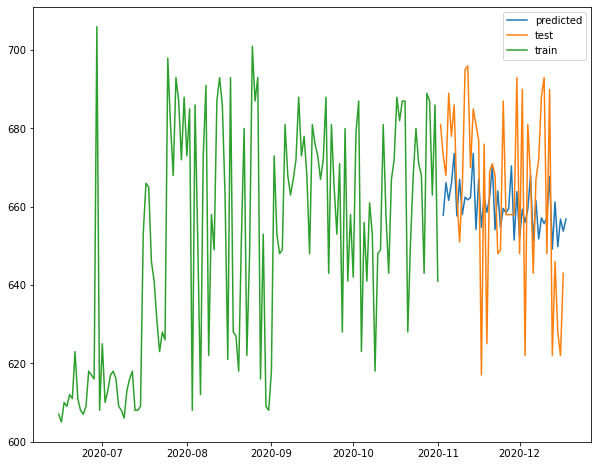

In [137]:
plt.figure(figsize= (10,8))
plt.plot(sarima_yhat, label = "predicted")
plt.plot(test["Available_beds"], label = "test")
plt.plot(tr["Available_beds"], label = "train")
plt.legend(loc="upper right")
plt.show()

In [80]:
sarima = sm.tsa.statespace.SARIMAX(val_tr, order= (2,0,2), seasonal_order= (0,1,1,7))

sarima_model = sarima.fit()

sarima_yhat= sarima_model.predict(start=307, end= 366,dynamic= True)
sarima_yhat.shape

(60,)

In [79]:
test

,Available_beds,forecasted
collection_date,,
2020-11-02,681.0,650.364286
2020-11-03,673.0,650.364286
2020-11-04,668.0,650.364286
2020-11-05,689.0,650.364286
2020-11-06,678.0,650.364286
2020-11-07,686.0,650.364286
2020-11-08,663.0,650.364286
2020-11-09,651.0,650.364286
2020-11-10,665.0,650.364286


#### SARIMA TEST RMSE

In [81]:
# test rmse sarima

Sarima_rmse= sqrt(mean_squared_error(sarima_yhat, val_test["Available_beds"]))
Sarima_rmse

31.417961063499618

In [82]:
# Whole data RMSE:

sarima = sm.tsa.statespace.SARIMAX(w_train, order= (2,0,2), seasonal_order= (0,1,1,7))

sarima_model = sarima.fit()

sarima_yhat= sarima_model.predict(start=331, end= 366,dynamic= True)
sarima_yhat.shape

(36,)

#### SARIMA WHOLE DATA RMSE

In [83]:
Sarima_rmse= sqrt(mean_squared_error(sarima_yhat, w_test))
Sarima_rmse

33.87100405446521

# Data- Based Forecasting Models:
  * simple average method
  * moving average method
  * exponential Smoothing
    * simple exponential smoothing
    * holts- Method/ Double exponential smoothing
    * holts- Winter Method

## Simple Average

In [84]:
yhat_average_train=test.copy()
yhat_average_train

,Available_beds,forecasted
collection_date,,
2020-11-02,681.0,650.364286
2020-11-03,673.0,650.364286
2020-11-04,668.0,650.364286
2020-11-05,689.0,650.364286
2020-11-06,678.0,650.364286
2020-11-07,686.0,650.364286
2020-11-08,663.0,650.364286
2020-11-09,651.0,650.364286
2020-11-10,665.0,650.364286


In [85]:
tr

,Available_beds
collection_date,
2020-06-15,607.0
2020-06-16,605.0
2020-06-17,610.0
2020-06-18,609.0
2020-06-19,612.0
...,...
2020-10-28,689.0
2020-10-29,687.0
2020-10-30,663.0


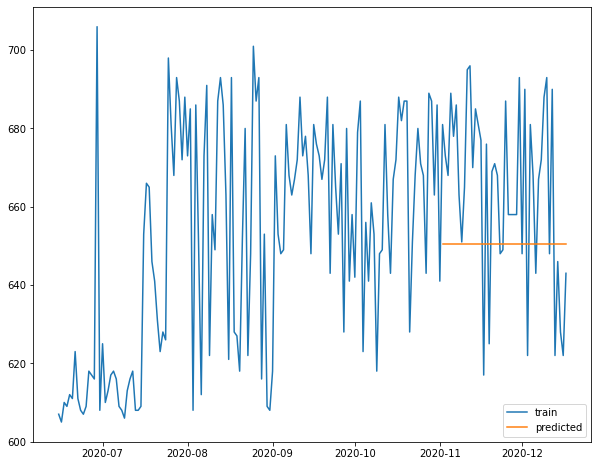

In [87]:
yhat_average_train["sa_forecast"]= tr["Available_beds"].mean()
plt.figure(figsize=(10,8))
plt.plot(train_data["Available_beds"], label = "train")
# plt.plot(test_data["Available_beds"], label =" test")
plt.plot(yhat_average_train["sa_forecast"], label= "predicted")
plt.legend(loc="lower right")
plt.show()

In [86]:
# yhat_average["sa_forecast"]= tr.mean()
# plt.figure(figsize=(10,8))
# plt.plot(train_data["Available_beds"], label = "train")
# plt.plot(test_data["Available_beds"], label =" test")
# plt.plot(yhat_average["sa_forecast"], label= "predicted")
# plt.legend(loc="lower right")
# plt.show()

In [88]:
# train RMSE FOR SIMPLE AVERAGE:

yhat_average_rmse= sqrt(mean_squared_error(yhat_average_train["sa_forecast"],yhat_average_train["Available_beds"]))
yhat_average_rmse

26.081949846749183

* Simple Average train RMSE

In [89]:
yhat_average_test= val_test.copy()

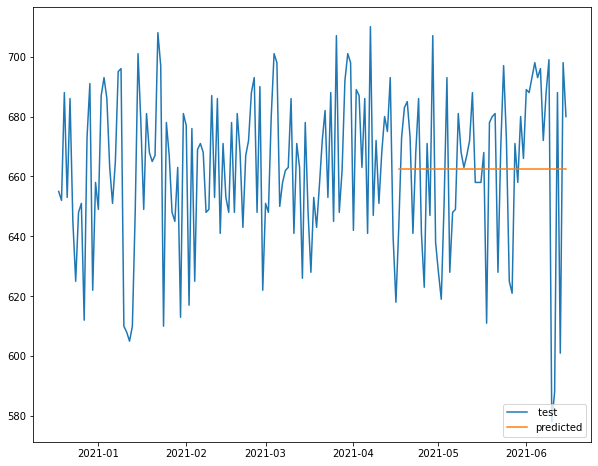

In [90]:
yhat_average_test["sa_forecast"]= val_tr["Available_beds"].mean()
plt.figure(figsize=(10,8))
# plt.plot(train_data["Available_beds"], label = "train")
plt.plot(test_data["Available_beds"], label =" test")
plt.plot(yhat_average_test["sa_forecast"], label= "predicted")
plt.legend(loc="lower right")
plt.show()

In [91]:
## Test rmse:
yhat_average_rmse_test= sqrt(mean_squared_error(yhat_average_test["sa_forecast"],val_test["Available_beds"]))
yhat_average_rmse_test

28.98445943758291

* Simple average test RMSE

In [92]:
## Whole_data_rmse

yhat_average_whole= test_data.copy()

yhat_average_whole["forecast_1"]=  train_data["Available_beds"].mean()

yhat_whole_rmse = sqrt(mean_squared_error(yhat_average_whole["forecast_1"], test_data["Available_beds"]))
yhat_whole_rmse

27.685463381446084

* SImple average whole data RMSE

# Moving average 

In [139]:


yhat_average_ma=test
yhat_average_ma["forecast_tr"] = tr["Available_beds"].rolling(31).mean().iloc[-1]

yhat_average_ma_trrmse= sqrt(mean_squared_error(yhat_average_ma["forecast_tr"],test["Available_beds"]))
yhat_average_ma_trrmse

22.003791836363796

* Moving Average train RMSE

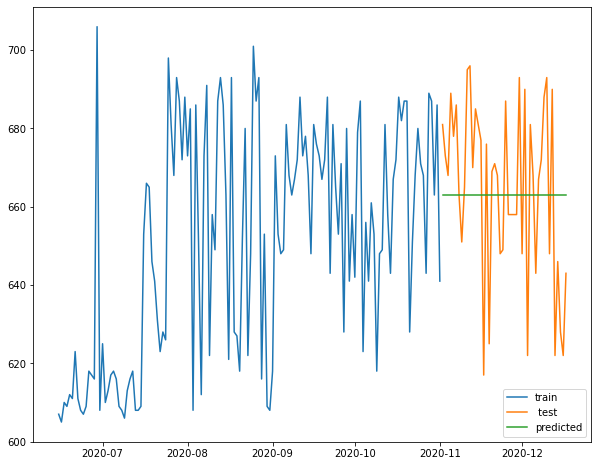

In [141]:
plt.figure(figsize=(10,8))
plt.plot(tr["Available_beds"], label = "train")
plt.plot(test["Available_beds"], label =" test")
plt.plot(yhat_average_ma[["forecast_tr"]], label= "predicted")
plt.legend(loc="lower right")
plt.show()

In [95]:
yhat_average_ma=test_data.copy()
yhat_average_ma["forecast_test"] =val_tr["Available_beds"].rolling(43).mean().iloc[-1]

yhat_average_ma_testrmse= sqrt(mean_squared_error(yhat_average_ma["forecast_test"],test_data["Available_beds"]))
yhat_average_ma_testrmse

26.49750774302276

* Moving Average Test RMSE

In [96]:
yhat_average_whole= test_data.copy()

yhat_average_whole["forecast_whole"] = train_data["Available_beds"].rolling(21).mean().iloc[-1]
yhat_average_whole_rmse= sqrt(mean_squared_error(yhat_average_whole["forecast_whole"], test_data["Available_beds"]))
yhat_average_whole_rmse

26.526115570438048

* Moving data moving average RMSE

## Simple Exponential Smoothing:

In [97]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [144]:
tr
sm_model = SimpleExpSmoothing(tr)
model = sm_model.fit()
se_model_yhat= model.predict(start="2020-11-02", end= "2020-12-17")
se_model_yhat

2020-11-02    666.799256
2020-11-03    666.799256
2020-11-04    666.799256
2020-11-05    666.799256
2020-11-06    666.799256
2020-11-07    666.799256
2020-11-08    666.799256
2020-11-09    666.799256
2020-11-10    666.799256
2020-11-11    666.799256
2020-11-12    666.799256
2020-11-13    666.799256
2020-11-14    666.799256
2020-11-15    666.799256
2020-11-16    666.799256
2020-11-17    666.799256
2020-11-18    666.799256
2020-11-19    666.799256
2020-11-20    666.799256
2020-11-21    666.799256
2020-11-22    666.799256
2020-11-23    666.799256
2020-11-24    666.799256
2020-11-25    666.799256
2020-11-26    666.799256
2020-11-27    666.799256
2020-11-28    666.799256
2020-11-29    666.799256
2020-11-30    666.799256
2020-12-01    666.799256
2020-12-02    666.799256
2020-12-03    666.799256
2020-12-04    666.799256
2020-12-05    666.799256
2020-12-06    666.799256
2020-12-07    666.799256
2020-12-08    666.799256
2020-12-09    666.799256
2020-12-10    666.799256
2020-12-11    666.799256


In [99]:
# test

In [100]:
se_model_train_rmse= sqrt(mean_squared_error(se_model_yhat, test["Available_beds"]))
se_model_train_rmse

22.088004870141926

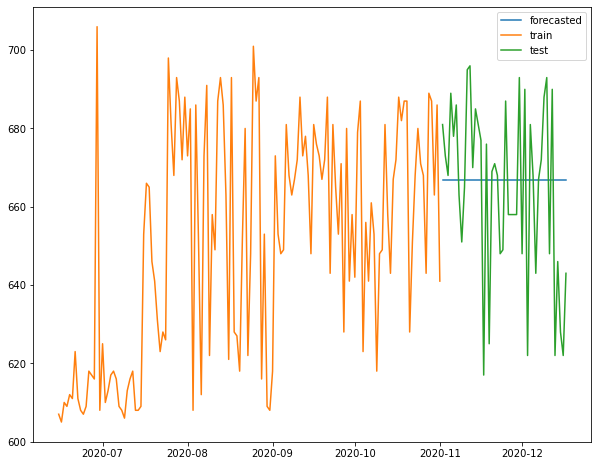

In [145]:
plt.figure(figsize=(10,8))
plt.plot(se_model_yhat, label= "forecasted")
plt.plot(tr["Available_beds"], label= "train")
plt.plot(test["Available_beds"], label = "test")
plt.legend(loc="upper right")
plt.show()

* Simple exponential smoothing train rmse

In [101]:
val_tr
sm_model = SimpleExpSmoothing(val_tr)
model = sm_model.fit()
se_model_yhat= model.predict(start="2021-04-17", end= "2021-06-15")
se_model_yhat

2021-04-17    662.466687
2021-04-18    662.466687
2021-04-19    662.466687
2021-04-20    662.466687
2021-04-21    662.466687
2021-04-22    662.466687
2021-04-23    662.466687
2021-04-24    662.466687
2021-04-25    662.466687
2021-04-26    662.466687
2021-04-27    662.466687
2021-04-28    662.466687
2021-04-29    662.466687
2021-04-30    662.466687
2021-05-01    662.466687
2021-05-02    662.466687
2021-05-03    662.466687
2021-05-04    662.466687
2021-05-05    662.466687
2021-05-06    662.466687
2021-05-07    662.466687
2021-05-08    662.466687
2021-05-09    662.466687
2021-05-10    662.466687
2021-05-11    662.466687
2021-05-12    662.466687
2021-05-13    662.466687
2021-05-14    662.466687
2021-05-15    662.466687
2021-05-16    662.466687
2021-05-17    662.466687
2021-05-18    662.466687
2021-05-19    662.466687
2021-05-20    662.466687
2021-05-21    662.466687
2021-05-22    662.466687
2021-05-23    662.466687
2021-05-24    662.466687
2021-05-25    662.466687
2021-05-26    662.466687


In [103]:
se_model_train_rmse= sqrt(mean_squared_error(se_model_yhat, val_test["Available_beds"]))
se_model_train_rmse

28.98445926023459

In [102]:
# val_test

* simple exponential smoothing test_rmse

In [104]:
train_data
sm_model = SimpleExpSmoothing(train_data)
model = sm_model.fit()
se_model_yhat= model.predict(start="2020-12-18", end= "2021-06-15")
se_model_yhat

2020-12-18    647.032587
2020-12-19    647.032587
2020-12-20    647.032587
2020-12-21    647.032587
2020-12-22    647.032587
                 ...    
2021-06-11    647.032587
2021-06-12    647.032587
2021-06-13    647.032587
2021-06-14    647.032587
2021-06-15    647.032587
Freq: D, Length: 180, dtype: float64

In [105]:
se_model_train_rmse= sqrt(mean_squared_error(se_model_yhat, test_data["Available_beds"]))
se_model_train_rmse

30.520190889060995

* Simple Exponential smoothing whole data RMSE

In [106]:
test_data

,Available_beds
collection_date,
2020-12-18,655
2020-12-19,652
2020-12-20,688
2020-12-21,653
2020-12-22,686
...,...
2021-06-11,588
2021-06-12,688
2021-06-13,601


## Double Exponential smoothing

In [107]:
tr
de_model= ExponentialSmoothing(tr)
de_model= de_model.fit()
de_model_train_predict = de_model.predict(start="2020-11-02", end= "2020-12-17")

2020-11-02    666.799256
2020-11-03    666.799256
2020-11-04    666.799256
2020-11-05    666.799256
2020-11-06    666.799256
2020-11-07    666.799256
2020-11-08    666.799256
2020-11-09    666.799256
2020-11-10    666.799256
2020-11-11    666.799256
2020-11-12    666.799256
2020-11-13    666.799256
2020-11-14    666.799256
2020-11-15    666.799256
2020-11-16    666.799256
2020-11-17    666.799256
2020-11-18    666.799256
2020-11-19    666.799256
2020-11-20    666.799256
2020-11-21    666.799256
2020-11-22    666.799256
2020-11-23    666.799256
2020-11-24    666.799256
2020-11-25    666.799256
2020-11-26    666.799256
2020-11-27    666.799256
2020-11-28    666.799256
2020-11-29    666.799256
2020-11-30    666.799256
2020-12-01    666.799256
2020-12-02    666.799256
2020-12-03    666.799256
2020-12-04    666.799256
2020-12-05    666.799256
2020-12-06    666.799256
2020-12-07    666.799256
2020-12-08    666.799256
2020-12-09    666.799256
2020-12-10    666.799256
2020-12-11    666.799256


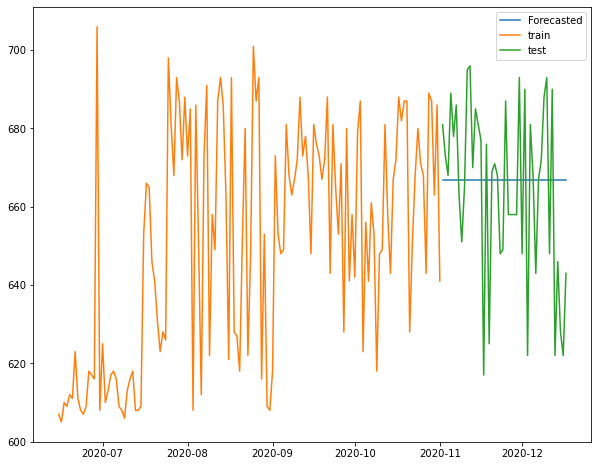

In [146]:
plt.figure(figsize= (10,8))
plt.plot(de_model_train_predict, label = "Forecasted")
plt.plot(tr["Available_beds"], label = "train")
plt.plot(test["Available_beds"],label= "test" )
plt.legend(loc="upper right")
plt.show()

In [108]:

de_model_tr_rmse= sqrt(mean_squared_error(de_model_train_predict, test["Available_beds"]))
de_model_tr_rmse


22.088004870141926

* Double exponential smoothing train RMSE:

In [110]:
de_model= ExponentialSmoothing(val_tr)
de_model= de_model.fit()
d = de_model.predict(start="2021-04-17", end= "2021-06-15")
d


de_model_test_rmse= sqrt(mean_squared_error(d, val_test["Available_beds"]))
de_model_test_rmse

28.98445926023459

*  double exponential test RMSE

In [114]:
train_data
de_model= ExponentialSmoothing(train_data)
de_model= de_model.fit()
de_model_whole_predict = de_model.predict(start="2020-12-18", end= "2021-06-15")
de_model_whole_predict

2020-12-18    647.032587
2020-12-19    647.032587
2020-12-20    647.032587
2020-12-21    647.032587
2020-12-22    647.032587
                 ...    
2021-06-11    647.032587
2021-06-12    647.032587
2021-06-13    647.032587
2021-06-14    647.032587
2021-06-15    647.032587
Freq: D, Length: 180, dtype: float64

In [115]:
de_model_whole_rmse= sqrt(mean_squared_error(de_model_whole_predict, test_data["Available_beds"]))
de_model_whole_rmse

30.520190889060995

* DOUBLE EXPONENTIAL SMOOTHING WHOLE DATA RMSE

##  holts winter method:

In [116]:
tr
hw_model = ExponentialSmoothing(tr.values, seasonal = "add", seasonal_periods= 15).fit()
yhat_hw_model= hw_model.forecast(len(test))
yhat_hw_model


array([670.28835238, 657.19491444, 657.56226427, 664.24232998,
       657.24136302, 665.75019933, 670.80703102, 668.11461614,
       677.76669397, 673.13155779, 671.3895872 , 665.31449702,
       658.94063183, 672.53828595, 662.67930556, 670.28835238,
       657.19491444, 657.56226427, 664.24232998, 657.24136302,
       665.75019933, 670.80703102, 668.11461614, 677.76669397,
       673.13155779, 671.3895872 , 665.31449702, 658.94063183,
       672.53828595, 662.67930556, 670.28835238, 657.19491444,
       657.56226427, 664.24232998, 657.24136302, 665.75019933,
       670.80703102, 668.11461614, 677.76669397, 673.13155779,
       671.3895872 , 665.31449702, 658.94063183, 672.53828595,
       662.67930556, 670.28835238])

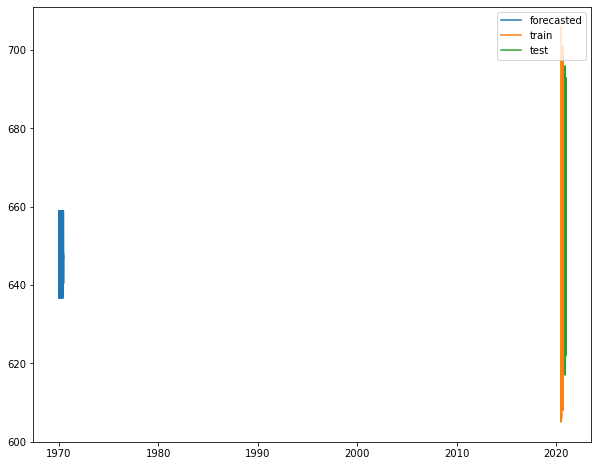

In [147]:
plt.figure(figsize=(10,8))
plt.plot(yhat_hw_model, label= "forecasted")
plt.plot(tr["Available_beds"], label = "train")
plt.plot(test["Available_beds"], label = "test")
plt.legend(loc="upper right")
plt.show()

In [117]:
hw_train_rmse= sqrt(mean_squared_error(yhat_hw_model, test["Available_beds"]))
hw_train_rmse

21.605488034576403

* hw train RMSE

In [127]:

hw_model = ExponentialSmoothing(val_tr.values, seasonal = "add", seasonal_periods= 15).fit()
val_test["hw_forecasted"]= hw_model.forecast(len(val_test))

hw_test_rmse= sqrt(mean_squared_error(val_test["hw_forecasted"], val_test["Available_beds"]))
hw_test_rmse

28.284214729636908

* HW TESST RMSE

In [119]:
train_data
hw_model = ExponentialSmoothing(train_data.values, seasonal = "add", seasonal_periods= 15).fit()
yhat_hw_model= hw_model.forecast(len(test_data))
yhat_hw_model

array([636.72948774, 637.36832056, 646.8404647 , 638.81088034,
       647.70183124, 648.42350676, 646.89410008, 658.95101224,
       651.92282172, 654.13586811, 642.26411442, 640.62204727,
       652.21180048, 640.41709209, 647.46829193, 636.72948774,
       637.36832056, 646.8404647 , 638.81088034, 647.70183124,
       648.42350676, 646.89410008, 658.95101224, 651.92282172,
       654.13586811, 642.26411442, 640.62204727, 652.21180048,
       640.41709209, 647.46829193, 636.72948774, 637.36832056,
       646.8404647 , 638.81088034, 647.70183124, 648.42350676,
       646.89410008, 658.95101224, 651.92282172, 654.13586811,
       642.26411442, 640.62204727, 652.21180048, 640.41709209,
       647.46829193, 636.72948774, 637.36832056, 646.8404647 ,
       638.81088034, 647.70183124, 648.42350676, 646.89410008,
       658.95101224, 651.92282172, 654.13586811, 642.26411442,
       640.62204727, 652.21180048, 640.41709209, 647.46829193,
       636.72948774, 637.36832056, 646.8404647 , 638.81

In [120]:
hw_whole_rmse= sqrt(mean_squared_error(yhat_hw_model, test_data["Available_beds"]))
hw_whole_rmse

31.884376592185216

* HW WHOLE DATA RMSE